# Emotion Detection

**Importing Libraries**

In [1]:
import sys

print("Python version:", sys.version)



Python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]


In [12]:
!pip install opencv-python

In [2]:
import cv2

In [3]:
import matplotlib.pyplot as plt
from glob import glob 
import random 
import os
import cv2
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display  import SVG, Image
import tensorflow as tf
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.19.0


**Exploring Dataset**

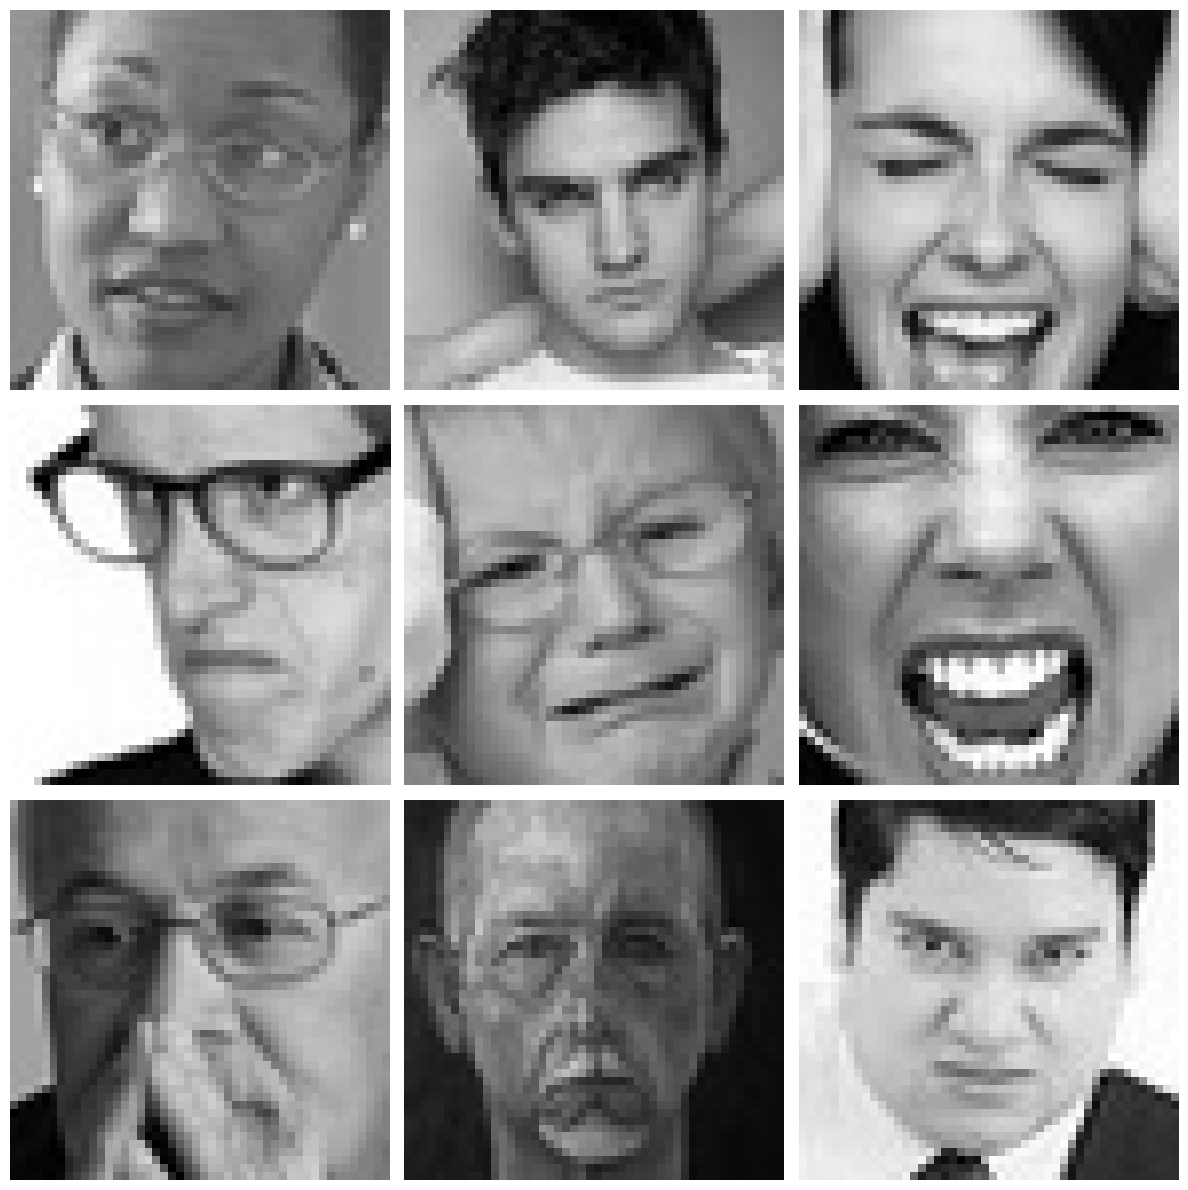

In [4]:
images = glob("train/**/**")
image_paths = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
plt.figure(figsize=(12,12))
for i in range(9):
    image = random.choice(image_paths)
    img = cv2.imread(image)

    if img is None:
        print(f"Warning: Could not read image {image}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()
    

**Preparing Data For Training**

In [6]:
img_size = 48
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
datagen_train = ImageDataGenerator()
train_generator = datagen.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 7543 images belonging to 4 classes.
Found 1885 images belonging to 4 classes.


**Defining the Model**

In [9]:
def Convolution(input_tensor,filters,kernel_size):
    X=Conv2D(filters=filters,kernel_size=kernel_size,padding="same")(input_tensor)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X=MaxPooling2D(pool_size=(2,2))(X)
    X=Dropout(0.25)(X)
    return X

In [10]:
def Dense_f(input_tensor,nodes):
    X=Dense(nodes)(input_tensor)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X=Dropout(0.25)(X)
    return  X

In [11]:
num_classes = train_generator.num_classes
print("Detected number of classes:", num_classes)


Detected number of classes: 4


In [13]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1= Convolution(inputs,32,(3,3))
    conv_2= Convolution(inputs,64,(5,5))
    conv_3= Convolution(inputs,128,(3,3))
    
    flatten=Flatten()(conv_3)
    
    dense_1=Dense_f(flatten,256)

   
    output=Dense(4,activation="softmax")(dense_1)
    model=Model(inputs=[inputs],outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam',metrics =['accuracy'])
    return model

In [14]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,878,468 (72.02 MB)

 Trainable params: 18,877,700 (72.01 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
epochs = 7
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

# Training the model

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/7
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4291 - loss: 1.4436
Epoch 1: saving model to model.weights.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.4295 - loss: 1.4416 - val_accuracy: 0.4305 - val_loss: 1.0835
Epoch 2/7
  1/117 ━━━━━━━━━━━━━━━━━━━━ 2:29 1s/step - accuracy: 0.4375 - loss: 1.0401
Epoch 2: saving model to model.weights.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4375 - loss: 1.0401 - val_accuracy: 0.4305 - val_loss: 1.0829
Epoch 3/7
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5800 - loss: 0.9545
Epoch 3: saving model to model.weights.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5801 - loss: 0.9545 - val_accuracy: 0.5005 - val_loss: 1.0682
Epoch 4/7
  1/117 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.5000 - loss: 1.0264
Epoch 4: saving model to model.weights.h5
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5000 - loss: 1.0264 - val_accuracy: 0.5027 - val_loss: 1.0671
Epoch 5/7
117/117 ━━

**model evaluation**

In [17]:
model.evaluate(validation_generator)

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.6681 - loss: 0.8520


[0.9962283968925476, 0.5421750545501709]

**plotting loss curve**

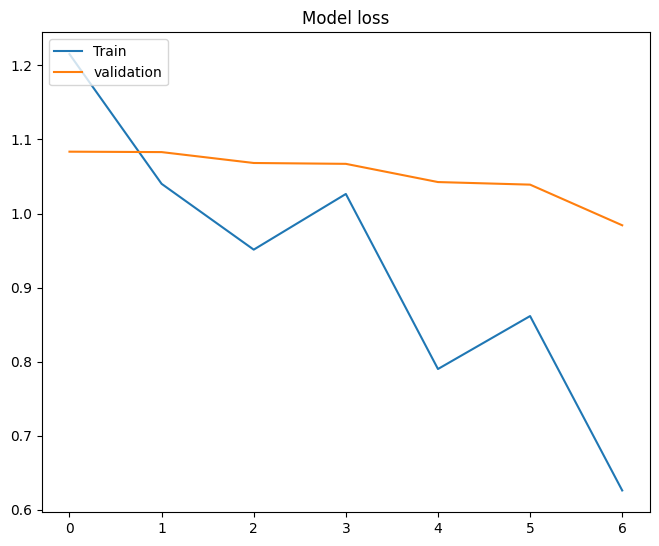

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.legend(['Train','validation'], loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

Text(0.5, 1.0, 'Model accuracy')

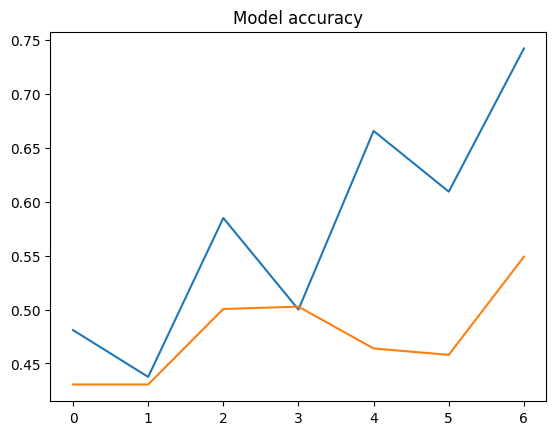

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

**Saving Model**

In [22]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)